In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
groq_api_key=os.getenv("GROQ_API_KEY")
model = ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")

In [2]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def multiply(first_number: int, second_number: int)->int:
    """Multiplies two interger together."""
    return first_number * second_number

@tool
def search(query: str):
    """perform web search on the user query"""
    tavily = TavilySearchResults(max_results=1)
    result = tavily.invoke(query)
    return result
     

## Combine the tools and Bind to the LLM

In [3]:

tools = [search,multiply]
     

In [4]:
tools[0]

StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001B99D766520>)

In [5]:
tools[0].invoke("Who is the president of the United States?")

C:\Users\hp\AppData\Local\Temp\ipykernel_5516\441313746.py:12: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=1)


[{'title': 'President Donald J. Trump - The White House',
  'url': 'https://www.whitehouse.gov/administration/donald-j-trump/',
  'content': '[Skip to content](https://www.whitehouse.gov/administration/donald-j-trump/#wp--skip-link--target) [The White House](https://www.whitehouse.gov/ "The White House") *   [News](https://www.whitehouse.gov/news/) *   [Back](https://www.whitehouse.gov/administration/donald-j-trump/#) *   [Articles](https://www.whitehouse.gov/articles/) *   [Back](https://www.whitehouse.gov/administration/donald-j-trump/#) *   [Remarks](https://www.whitehouse.gov/remarks/) *   [Administration](https://www.whitehouse.gov/administration/) *   [Back](https://www.whitehouse.gov/administration/donald-j-trump/#) Trump](https://www.whitehouse.gov/administration/donald-j-trump/) *   [JD Vance](https://www.whitehouse.gov/administration/jd-vance/) *   [Melania Trump](https://www.whitehouse.gov/administration/melania-trump/) *   [The Cabinet](https://www.whitehouse.gov/administra

In [6]:
tool_map = {tool.name: tool for tool in tools}

In [7]:
tool_map

{'search': StructuredTool(name='search', description='perform web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001B99D766520>),
 'multiply': StructuredTool(name='multiply', description='Multiplies two interger together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001B99D766480>)}

In [8]:
model_with_tools = model.bind_tools(tools)

In [9]:
model_with_tools 

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B99E9F2330>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B99EA1EBA0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'perform web search on the user query', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiplies two interger together.', 'parameters': {'properties': {'first_number': {'type': 'integer'}, 'second_number': {'type': 'integer'}}, 'required': ['first_number', 'second_number'], 'type': 'object'}}}]}, config={}, config_factories=[])

## Checking the tool calling with Specific questions

In [ ]:
res = model_with_tools.invoke('what is generative AI? and multiply 12 and 15')
res

# Model_with_tools returns the tool calls made during the invocation not the final answer.

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mynwwkz1q', 'function': {'arguments': '{"query":"generative AI"}', 'name': 'search'}, 'type': 'function'}, {'id': 'zs6kvm6qd', 'function': {'arguments': '{"first_number":12,"second_number":15}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 286, 'total_tokens': 320, 'completion_time': 0.04628691, 'prompt_time': 0.01564277, 'queue_time': 0.048896689, 'total_time': 0.06192968}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c5a8df39-b152-4050-ac47-e38a6fd27082-0', tool_calls=[{'name': 'search', 'args': {'query': 'generative AI'}, 'id': 'mynwwkz1q', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'first_number': 12, 'second_number': 15}, 'id': 'zs6kvm6qd', 'type': 'tool_call'}], usage_metadata={'input_to

In [ ]:
for tool_call in res.additional_kwargs.get("tool_calls", []):
    print(tool_call)  # ID , FUNCTION , Type
    print("-"*100)

{'id': 'mynwwkz1q', 'function': {'arguments': '{"query":"generative AI"}', 'name': 'search'}, 'type': 'function'}
----------------------------------------------------------------------------------------------------
{'id': 'zs6kvm6qd', 'function': {'arguments': '{"first_number":12,"second_number":15}', 'name': 'multiply'}, 'type': 'function'}
----------------------------------------------------------------------------------------------------


In [18]:
print(tool_call['function'])
print("-"*50)
print(tool_call['function']['arguments'])

{'arguments': '{"first_number":12,"second_number":15}', 'name': 'multiply'}
--------------------------------------------------
{"first_number":12,"second_number":15}


In [ ]:
tool_map[tool_call['function']['name']].invoke(tool_call['function']['arguments'])   #

ValidationError: 2 validation errors for multiply
first_number
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='{"first_number":12,"second_number":15}', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/int_parsing
second_number
  Field required [type=missing, input_value={'first_number': '{"first...12,"second_number":15}'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing

In [23]:
import json
tool_args = json.loads(tool_call['function']['arguments']) 
tool_args

{'first_number': 12, 'second_number': 15}

In [25]:
tool_map[tool_call['function']['name']].invoke(tool_args)   

180

In [20]:
res = model_with_tools.invoke('What is 12 *555')
for i in res.additional_kwargs.get("tool_calls", []):
    print(i)

{'id': 'jwwbnzfgq', 'function': {'arguments': '{"first_number":12,"second_number":555}', 'name': 'multiply'}, 'type': 'function'}


- In Python, the variable i declared in a for loop remains in scope after the loop ends.
It doesn’t get destroyed when the loop finishes — it just keeps the last assigned value.

In [13]:
i   # last tool call

{'id': 'rkeed0qzw',
 'function': {'arguments': '{"first_number":12,"second_number":555}',
  'name': 'multiply'},
 'type': 'function'}

## Graph creation

In [26]:
from typing import TypedDict, Annotated, Sequence
import operator,json
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [27]:
def invoke_model(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [28]:
AgentState['messages']

__main__.AgentState['messages']

###  Bring human in the loop

-- Bring human approval for costly tool calls or where we need validation

In [29]:
def invoke_tool(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    tool_details = None

    for tool_call in tool_calls:
        tool_details = tool_call

    if tool_details is None:
        raise Exception("No adder input found.")

    print(f'Selected tool: {tool_details.get("function").get("name")}')

    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            # raise ValueError
            print("Aborting web search as per user request.")
            return {"messages" : ["Aborted web search as per user request."]}


    response = tool_map[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [30]:

from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState) 

graph.add_node("agent", invoke_model)
graph.add_node("tool", invoke_tool)

def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

graph.add_conditional_edges("agent", router, {
    "tool": "tool",
    "end": END,
})

graph.add_edge("tool", END)

graph.set_entry_point("agent")

In [31]:
workflow = graph.compile()

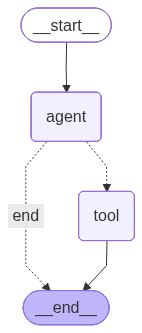

In [32]:
workflow

In [21]:
# %pip install pygraphviz

In [22]:
# from IPython.display import Image, display
# display(Image(workflow.get_graph().draw_png()))

In [33]:
for s in workflow.stream({"messages": ["What is 24 * 365?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ns9j4r9ep', 'function': {'arguments': '{"first_number":24,"second_number":365}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 281, 'total_tokens': 302, 'completion_time': 0.031769167, 'prompt_time': 0.015422315, 'queue_time': 0.055249705, 'total_time': 0.047191482}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--d0a451ab-0592-4a34-908a-6aa8cea898bd-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 24, 'second_number': 365}, 'id': 'ns9j4r9ep', 'type': 'tool_call'}], usage_metadata={'input_tokens': 281, 'output_tokens': 21, 'total_tokens': 302})]}
----
Selected tool: multiply
{'messages': [8760]}
----


In [37]:
for s in workflow.stream({"messages": ["Who  is the president of the United States?"]}):
    print(s)
    print(",,,,"*50)
    print(list(s.values()))
    print("----")
     

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dmmadkbh0', 'function': {'arguments': '{"query":"president of the United States"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 283, 'total_tokens': 307, 'completion_time': 0.044559728, 'prompt_time': 0.01554917, 'queue_time': 0.054507579, 'total_time': 0.060108898}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--477784c1-496b-456c-abfc-dbfb5be1cf7b-0', tool_calls=[{'name': 'search', 'args': {'query': 'president of the United States'}, 'id': 'dmmadkbh0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 283, 'output_tokens': 24, 'total_tokens': 307})]}}
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [25]:
for s in workflow.stream({"messages": ["Who won the T20 Cricket world cup in 2022?"]}):
    print(list(s.values())[0])
    print("----")
     

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cwajmq9h3', 'function': {'arguments': '{"query":"T20 Cricket world cup 2022 winner"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.029391254, 'prompt_time': 0.01625384, 'queue_time': 0.04913972, 'total_time': 0.045645094}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--e26e0cd4-e0b0-4ce1-a5c7-74e25b261350-0', tool_calls=[{'name': 'search', 'args': {'query': 'T20 Cricket world cup 2022 winner'}, 'id': 'cwajmq9h3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]}
----
Selected tool: search
{'messages': [[{'title': "2022 Men's T20 World Cup final - Wikipedia", 'url': 'https://en.wikipedia.org/